## Offense target identification

This is the task 'c' in Task 6: OffensEval: Identifying and Categorizing Offensive Language in Social Media in SemEval 2019. We have explored how a neural network with lstm and attention can be used in offense target identification. 

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
import os
import time
import gc
import re
from unidecode import unidecode

Using TensorFlow backend.


### Loading the training and testing files

In [3]:
# Filter the non offensive posts in the training set
train = pd.read_csv("Data/training/offenseval-training-v1.tsv", sep='\t')
train = train.loc[train['subtask_a'] == 'OFF']
train = train.loc[train['subtask_b'] == 'TIN']

test_tweets = pd.read_csv("Data/testing/test_set_taskc.tsv", sep='\t')
test_labels = pd.read_csv("Data/testing/labels-test-c.csv", header=-1, names = ["id", "subtask_c"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (3876, 5)
Test shape :  (213, 3)


Changing case of the tweets to lower case, since the embedding model only has lower case words

In [4]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

cleaning the puncutation marks

In [5]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

In [7]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 72 # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_c'].values
Y

array(['IND', 'OTH', 'GRP', ..., 'GRP', 'IND', 'OTH'], dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

num_classes = np.max(encoded_Y) + 1

Building the Embedding matrix

In [9]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/data/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/data/fasttext/crawl-300d-2M-subword.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

Only Glove vectors have been used in embedding matrix. Can explore it further in future

In [10]:
embedding_matrix = load_glove(word_index)

Definning the Capsule Layer in Keras

In [11]:
# https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

Capsule Layer with a Bi directional GRU. Architecture found in text classification project.

In [12]:
def lstm_attention():
    K.clear_session()       
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64,return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(256, activation="relu")(x)
    # x = Dropout(0.25)(x)
    x = Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Training with early stopping and reducing learning rate on plateu. In each fold values for the test set is also predicted, And after the process, predicted values for the test file would be mean from each fold

In [15]:
from keras import utils

kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
bestscore = []
y_test = np.zeros((X_test.shape[0], num_classes))
for i, (train_index, valid_index) in enumerate(kfold.split(X, encoded_Y)):
    X_train, X_val, Y_train, Y_val = X[train_index], X[valid_index], encoded_Y[train_index], encoded_Y[valid_index]
    filepath="Models/lstm_attention_weights_best.h5"
    Y_train_encoded = utils.to_categorical(Y_train, num_classes)
    Y_val_encoded = utils.to_categorical(Y_val, num_classes)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.0001, verbose=2)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
    callbacks = [checkpoint, reduce_lr]
    model = lstm_attention()
    if i == 0:print(model.summary()) 
    model.fit(X_train, Y_train_encoded, batch_size=64, epochs=20, validation_data=(X_val, Y_val_encoded), verbose=2, callbacks=callbacks, 
             )
    model.load_weights(filepath)
    y_pred = model.predict([X_val], batch_size=64, verbose=2)
    y_test += np.squeeze(model.predict([X_test], batch_size=64, verbose=2))/5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 72, 300)           2978100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 72, 128)           186880    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 72, 128)           98816     
_________________________________________________________________
attention_1 (Attention)      (None, 128)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total para


Epoch 00002: val_loss improved from 0.50294 to 0.44011, saving model to Models/lstm_attention_weights_best.h5
Epoch 3/20
 - 4s - loss: 0.4151 - acc: 0.8184 - val_loss: 0.4356 - val_acc: 0.8082

Epoch 00003: val_loss improved from 0.44011 to 0.43557, saving model to Models/lstm_attention_weights_best.h5
Epoch 4/20
 - 4s - loss: 0.4061 - acc: 0.8230 - val_loss: 0.4295 - val_acc: 0.8034

Epoch 00004: val_loss improved from 0.43557 to 0.42951, saving model to Models/lstm_attention_weights_best.h5
Epoch 5/20
 - 4s - loss: 0.3873 - acc: 0.8368 - val_loss: 0.4346 - val_acc: 0.7974

Epoch 00005: val_loss did not improve from 0.42951

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 6/20
 - 4s - loss: 0.3699 - acc: 0.8454 - val_loss: 0.4412 - val_acc: 0.7905

Epoch 00006: val_loss did not improve from 0.42951

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.
Epoch 7/20
 - 4s - loss: 0.3563 - acc: 0.8505 - val_loss: 0.4456 - va

 - 4s - loss: 0.3243 - acc: 0.8656 - val_loss: 0.4213 - val_acc: 0.8213

Epoch 00010: val_loss did not improve from 0.40163

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00012960000021848827.
Epoch 11/20
 - 4s - loss: 0.3111 - acc: 0.8743 - val_loss: 0.4284 - val_acc: 0.8157

Epoch 00011: val_loss did not improve from 0.40163

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 12/20
 - 4s - loss: 0.2995 - acc: 0.8816 - val_loss: 0.4334 - val_acc: 0.8165

Epoch 00012: val_loss did not improve from 0.40163
Epoch 13/20
 - 4s - loss: 0.2914 - acc: 0.8856 - val_loss: 0.4405 - val_acc: 0.8170

Epoch 00013: val_loss did not improve from 0.40163
Epoch 14/20
 - 4s - loss: 0.2834 - acc: 0.8881 - val_loss: 0.4539 - val_acc: 0.8135

Epoch 00014: val_loss did not improve from 0.40163
Epoch 15/20
 - 4s - loss: 0.2781 - acc: 0.8919 - val_loss: 0.4667 - val_acc: 0.8101

Epoch 00015: val_loss did not improve from 0.40163
Epoch 16/20
 - 4s - loss: 0.2702 - acc: 0.8965 -

Converting the predictions for integer.

In [16]:
encoded_pred = np.argmax(y_test, axis=1)
test['predictions'] = le.inverse_transform(encoded_pred)

### Confusion Matrix

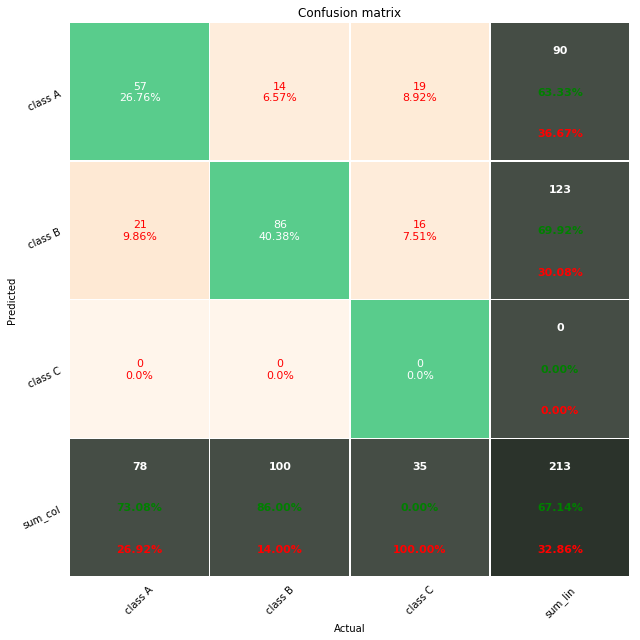

In [18]:
from visualization.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
# size::
fz = 12;
figsize = [9, 9];
if len(y_test) > 10:
    fz = 9;
    figsize = [14, 14];
plot_confusion_matrix_from_data(test["subtask_c"], test['predictions'], columns,
                                    annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Accuracy

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_c"], test['predictions'])

0.6713615023474179